In [1]:
import os
import numpy as np
import scipy.io as sio
from matplotlib import pyplot as plt
from evaluate import gen_ups_main, gen_downs_main, cal_F_D_DD

from ChangeFinder import chi2CUSUM


Bad key "text.kerning_factor" on line 4 in
g:\anaconda\envs\bjd\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# define function 

In [2]:
param = {'snr':             [5,         0,      -5,     -10,    -15,    -20],
         'noise_mean':      [0.03,      0.06,   0.11,   0.2,    0.34,   0.8],
         'noise_variance':  [0.0003,    0.001,  0.003,  0.013,    0.03,   0.1],
         'signal_mean':     [0.01,      0.98,   0.98,   0.99,   1.02,   1.06],
         'signal_variance': [0.0008,    0.0008, 0.014,  0.025,   0.08,   0.22],
         'bound':           [0.01,      0.01,   0.01,   0.01,   0.01,   0.02]}

def autoCPD(i, snr, ch_data, XDim, threshold):

    print('The '+str(i)+'th channel\n')

    #取模，也可以是别的操作
    sig_amp = np.abs(ch_data)
    X = sig_amp.reshape(-1,1)

    # get snr
    # snr = int(path.split('/')[-2][3:])
    snr_idx = param['snr'].index(snr)

    # get param
    up = [param['noise_mean'][snr_idx], param['signal_mean'][snr_idx]]
    down = [param['signal_mean'][snr_idx], param['noise_mean'][snr_idx]]
    sigma = [np.sqrt(param['noise_variance'][snr_idx]), np.sqrt(param['signal_variance'][snr_idx])]
    bound = param['bound']
    b2_up=(0.1/sigma[0])**2
    XDim=1
    batchsize = 10

    CUSUM = chi2CUSUM(XDim=XDim,threshold=threshold, theta_0 = up[0],sigma=sigma[0], b2=b2_up,r=2)

    stats = []

    flag='up'
    type = []
    ups = []
    downs = []

    for index, sample in enumerate(X):
        stat = CUSUM.update(sample)

        # # check the statistic
        # if flag=='down':
        #     k = len(CUSUM.ts) - 1
        #     print(CUSUM.calculateSkt_slash(k))


        stats.append(stat)
        if flag == 'up':
            type.append('red')
        else:
            type.append('green')

        if flag == 'down' and np.any(X[index] < bound):
            downs.append(index)
            print("DO NOT DETECT DOWN, SWITCH TO UP")
            # if index > X.shape[0]-batchsize:
            #     minibatch = X[index:]
            # else:
            #     minibatch = X[index:index+batchsize]

            # theta_0 = np.mean(minibatch)
            # sigma_0 = np.sqrt(np.var(minibatch))
            # b2 = (0.1/sigma_0)**2    
            # 
            theta_0  = up[0]
            sigma_0  = sigma[0]
            b2 = b2_up    
            
            CUSUM.initialize()
            CUSUM.updata_prior(theta_0=theta_0, sigma_0=sigma_0, b2=b2)
            # CUSUM = chi2CUSUM(XDim=XDim,threshold=threshold, theta_0 = up[0],sigma=sigma[0], b2=b2_up,r=2)
            flag = 'up'
            continue

        # 上升沿检测器
        if stat > threshold and flag=='up':

            ups.append(index)
            if index > X.shape[0]-batchsize:
                minibatch = X[index:]
            else:
                minibatch = X[index:index+batchsize]

            theta_0 = np.mean(minibatch)
            sigma_0 = np.sqrt(np.var(minibatch))
            b2 = (0.1/sigma_0)**2     

            CUSUM.initialize()
            CUSUM.updata_prior(theta_0=theta_0, sigma_0=sigma_0, b2=b2)

            flag = 'down'
            continue

        if stat > threshold and flag=='down':

            downs.append(index)

            # if index > X.shape[0]-batchsize:
            #     minibatch = X[index:]
            # else:
            #     minibatch = X[index:index+batchsize]

            # theta_0 = np.mean(minibatch)
            # sigma_0 = np.sqrt(np.var(minibatch))
            # b2 = (0.1/sigma_0)**2     
            theta_0  = up[0]
            sigma_0  = sigma[0]
            b2 = b2_up

            CUSUM.initialize()
            CUSUM.updata_prior(theta_0=theta_0, sigma_0=sigma_0, b2=b2)
            
            flag = 'up'
            continue
    return i, [ups,downs],stats,type

# get data

In [3]:
chdata_ex_path = 'ch_sig.mat'
chdata=sio.loadmat(chdata_ex_path)
chdata.keys()
signal = chdata['ch_sig']
label = chdata['ch_label']
label

array([[ 1852,  2789,     1,     1],
       [ 5598,  6535,     3,     1],
       [ 8449,  9387,     3,     3],
       [11430, 11440,     5,     2],
       [12293, 13231,     3,     2],
       [13711, 14648,     3,     1],
       [17590, 18527,     3,     4]], dtype=uint16)

# plot data

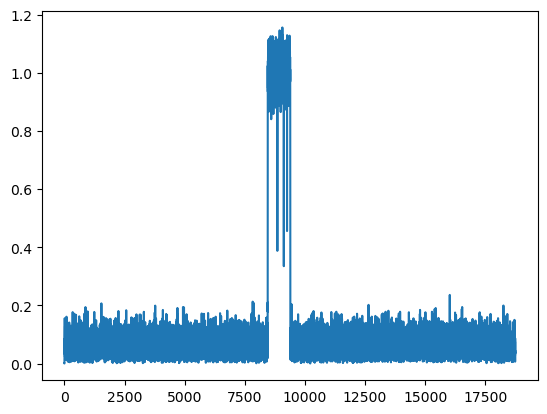

In [4]:
sig = signal[213,:]
# sig_next = signal[235,:]
# sig = sig_now + sig_next
sig_real = np.real(sig)
sig_imag = np.imag(sig)
sig_amp = np.abs(sig)

# sig_amp = np.abs(sig_now) + np.abs(sig_next)
plt.plot(sig_amp)
X = sig_amp.reshape(-1,1)

# autoCPD

In [8]:
XDim=1
threshold = 10
snr = 0
i = 213

i, [up,down], stats,types = autoCPD(i, snr, sig, XDim, threshold)

The 213th channel



Text(0, 0.5, 'CPD statistic')

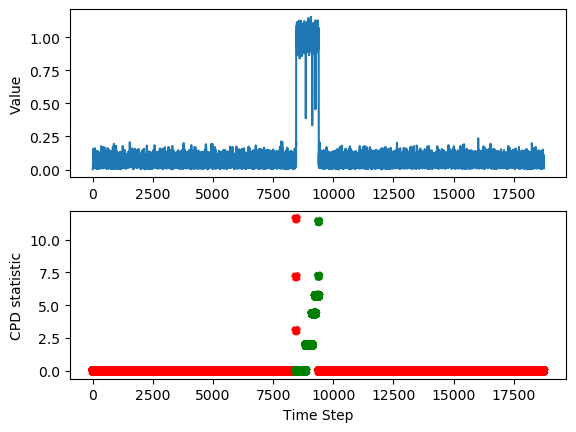

In [9]:
fig = plt.figure()
plt.subplot(211)
plt.plot(X)
plt.ylabel('Value')
# plt.xticks([])
# plt.title(filepath.split('/')[-2])

plt.subplot(212)
plt.scatter(range(len(stats)),stats,linestyle='--',c=types)
# plt.xlim(0,N)
plt.xlabel('Time Step')
plt.ylabel('CPD statistic')

## evaluate

In [10]:
channels = [170,192,213,234]

chs_label = [i]
ups_label = []
mop_label = []
downs_label = []
for l in label:
    if l[3]==3:
        ups_label.append(l[0])
        downs_label.append(l[1])
        mop_label.append(l[2]-1)

ups = []
downs = []
chs = []
if len(up)!=0 or len(down)!=0:
    ups.append(up)
    downs.append(down)
    chs.append(i)

ups_main = gen_ups_main(chs,chs_label,ups)
label


array([[ 1852,  2789,     1,     1],
       [ 5598,  6535,     3,     1],
       [ 8449,  9387,     3,     3],
       [11430, 11440,     5,     2],
       [12293, 13231,     3,     2],
       [13711, 14648,     3,     1],
       [17590, 18527,     3,     4]], dtype=uint16)

In [11]:
chs,chs_label,ups

([213], [213], [[8456]])

In [12]:
ups_label, ups_main

([8449], [8456])

In [13]:
false,alarm_num, detect, pulse_num, DD = cal_F_D_DD(ups_label, ups_main, tol= 1000)
print('FAR: '+str(false/alarm_num))
print('PD: '+str(detect/pulse_num))

FAR: 0.0
PD: 1.0
